In [233]:
import numpy as np
import healpy as hp
from matplotlib import pyplot as plt
import pysm3
import pysm3.units as u
%matplotlib inline

Using PySM3 to simulate foreground and cmb maps. The noise is simulated as a random process and linked to the noise sensitivity of Planck

In [234]:
#simulating foregroud emission and noise at the different Planck frequencies

nside = 128
#lmax =200 #maximum multipole moment

# Planck frequencies (in GHz)
freqs = np.array([28.4,  44.1,  70.4,  100.0,  143.0,  217.0,  353.0,  545.0,  857.0])
n_freqs = len(freqs)

# Planck noise sensitivity (in uK_arcmin)
sens = np.array([150.,  162.,  210.,  77.4,  33.,  46.8, 154,  42.,  5016.])

#Importing models for foregrounds and cmb using pysm sky module

sky_d = pysm3.Sky(nside=nside, preset_strings=["d1"])
sky_s = pysm3.Sky(nside=nside, preset_strings=["s1"])
sky_f = pysm3.Sky(nside=nside, preset_strings=["f1"])
sky_cmb = pysm3.Sky(nside=nside, preset_strings=["c1"])

# Initialization of lists to collect maps of different components at different frequencies
noise_pl = []
dust_pl = []
sync_pl = []
ff_pl = []
cmb_pl =[]
for nf in range(n_freqs):
    #noise
    noise= (np.random.normal(size=(12 * nside**2)) * sens[nf] / hp.nside2resol(nside, True))
    noise_pl.append(noise)
    #foregrounds
    dust= sky_d.get_emission(freqs[nf] * u.GHz)[0] * u.uK_RJ.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(freqs[nf] * u.GHz))
    dust_pl.append(dust)
    sync=sky_s.get_emission(freqs[nf] * u.GHz)[0] * u.uK_RJ.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(freqs[nf] * u.GHz))

    sync_pl.append(sync)
    ff=sky_f.get_emission(freqs[nf] * u.GHz)[0] * u.uK_RJ.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(freqs[nf] * u.GHz))
    ff_pl.append(ff)
    #cmb
    cmb = sky_cmb.get_emission(freqs[nf] * u.GHz)[0]* u.uK_RJ.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(freqs[nf] * u.GHz))
    cmb_pl.append(cmb)


# Making lists numpy arrays. Their dimension is (N_freq,N_pixels).
noise_pl=np.array(noise_pl)
dust_pl=np.array(dust_pl)
sync_pl=np.array(sync_pl)
ff_pl=np.array(ff_pl)
cmb_pl = np.array(cmb_pl)


Combining the CMB and foreground maps to be input into ILC

In [235]:
maps_pl = cmb_pl + noise_pl + dust_pl + sync_pl + ff_pl #cmb and foregrounds combined
fgds_pl= dust_pl + sync_pl + ff_pl #combined foregrounds
print(maps_pl.shape)

(9, 196608)


Transforimng frequency maps to harmonic space by decomposition

In [236]:
#transform maps to spherical harmonics
lmax=3*nside -1 #default is lmax= 3*nside+1
almsize=hp.Alm.getsize(lmax)
print(almsize)
print((lmax+1)**2)
print(lmax)
alm_maps=np.zeros((n_freqs, almsize), dtype=complex) #storing coefficients in an array of dim n_freqs*almsize. dtype is complex to account for -ive values
alm_fgds= np.zeros((n_freqs, almsize), dtype=complex)
for nf in range(n_freqs):
    alm_maps[nf,:]= hp.map2alm(maps_pl[nf,:], lmax=lmax, mmax=None, iter=0, pol=False) #record alm corresponding to each f for a corresponding l and m
    alm_fgds[nf,:]= hp.map2alm(fgds_pl[nf,:], lmax=lmax, mmax=None, iter=0, pol=False)

73920
147456
383


In [237]:
# alm contains a_lm(i) coefficients
print(alm_maps.shape) 
print(alm_fgds.shape) # Outputs: (lmax + 1)*(lmax + 2)//2, the number of coefficients
num_maps= len(alm_maps)
num_fgds= len(alm_fgds)
print(num_maps)

(9, 73920)
(9, 73920)
9


First Method:

Compute nf x nf Covariance matrix by fixing l for particular $a_{lm}$. Compute weights for every l

$$
\hat{C}_{l}^{ij} = \frac{1}{2l+1}\sum_{m=-l}^{+l} a_{lm}^{i}a^{j \dagger }_{lm}
$$

In [238]:
C_l= np.zeros((lmax+1,n_freqs, n_freqs), dtype=float)#lmax+1 x freq x freq
for l in range(lmax+1):
    index= np.zeros((l+1), dtype=int) 
    for m in range(l+1):
        index[m]=hp.Alm.getidx(lmax, l,m) #getting indices corresponding to each l and m for m>0
    
   
    alm_p=alm_maps[:, index] #subarray of alm maps. : takes all values from first dim (frequencies). 2nd dim the values of m>0


    alm = np.conj(alm_p) + alm_p #alm with positive and negative values

    C_l [l,:, :]= np.real(np.outer(alm_p[:, 0], alm_p[:,0])) #2d array from outer product alm_0
    
    for m in range(1,l+1): #sum over m
        C_l [l,:, :] += 2* np.real(np.outer(alm_p[:, m], np.conj(alm_p[:, m]))) #adding alm_p and negative ti C_l
print(alm_p.shape)
print(C_l.shape)
print(alm.shape)
    #for nf in range(n_freqs):
    #enumerate function
        #alm_p[nf,i]= alm_maps[nf,index]  #storing the alm in a 1d array corresponding to every freq
 

(9, 384)
(384, 9, 9)
(9, 384)


Now we can compute the inverse covariance matrix and compute the weights using $$\omega_i(l) = \frac{\sum_j (C_l^{-1})_{ij} b_{j}}{\sum_{ij}b_i (C_l^{-1})_{ij} b_{j}}$$

where $b_i $ represents the CMB transfer function. $b_i = [1,...,1]$

In [239]:
#CMB spectral energy density
b= np.ones(n_freqs, dtype=complex ) #array filled with values of 1. column vector

w= np.zeros((n_freqs, almsize), dtype=complex) #weights

for l in range(lmax+1):

    Cl_matrix = (1/(2*l+1))*C_l[l,:,:] #cov matrix for a specific l (nfreqs x nfreqs)
    

    Cl_inv = np.conj(Cl_matrix) #(nfreqs x nfreqs)
    numerator = np.dot(Cl_inv,  b) #nfreqs x 1
    denominator = np.dot(b.T, Cl_inv, b) #scalar?? 1x1
  

    for nf in range(n_freqs):
      w[nf,:] += numerator[nf]/denominator[nf]# (nfreqs x almsize) Since this is inside l loop it is only the weight for a specific l. looping will give us the correct shape?
print(Cl_matrix.shape)
print(Cl_inv.shape)
print(numerator.shape)
print(denominator.shape)
print(w.shape)
#issue in dividing? values too small

(9, 9)
(9, 9)
(9,)
(9,)
(9, 73920)


/tmp/ipykernel_4248/3406616935.py:17: RuntimeWarning: invalid value encountered in scalar divide
  w[nf,:] += numerator[nf]/denominator[nf]# (nfreqs x almsize) Since this is inside l loop it is only the weight for a specific l. looping will give us the correct shape?


In [240]:
cond_number = np.linalg.cond(Cl_matrix)
print(f"Condition number of C_l for l = {l}: {cond_number}") #too large

Condition number of C_l for l = 383: 7348251838316.922


Sum over frequencies to get $a_{ILC}$ for every l

$$a^{ILC}_{lm} = \sum_i w_i(l)a^i_{lm}$$

In [241]:
alm_ilc =np.zeros((n_freqs, almsize), dtype=complex)

for l in range(lmax+1):     #for every l compute the alm ilc 
    for nf in range(n_freqs):
        alm_ilc += np.dot(w[:,l],alm[:,l])  # (nf x 1) (nf, 1) = (nf, almsize) due to loop over l?
print(alm_ilc.shape)

(9, 73920)


In [242]:
for nf in range(n_freqs):
    map_out = hp.alm2map(alm_ilc[nf,:], nside, lmax=lmax, mmax=lmax, pol=False)
print(map_out.shape)

(196608,)


ALTERNATE METHOD

Compute nf x nf Covariance matrix by fixing l for particular $a_{lm}$. Compute weights for every l

$$
\hat{C}_{l}^{ij} = \frac{1}{2l+1}\sum_{m=-l}^{+l} a_{lm}^{i}a^{j \dagger }_{lm}
$$

In [255]:
#Alternate method
Cl= np.zeros((lmax+1,n_freqs, n_freqs), dtype=float) 


for l in range(lmax+1): #for every l
    
    #index already obtained in first method do not need to do it again?
    index= np.zeros((l+1), dtype=int) 
    for m in range(l+1):
        index[m]=hp.Alm.getidx(lmax, l,m) #getting indices corresponding to each l and m for m>0
    
   
    alm_p=alm_maps[:, index] #subarray of alm maps. : takes all values from first dim (frequencies). 2nd dim the values of m>0

    Cl [l,:,:]= np.real(np.outer(alm_p[:, 0], alm_p[:,0]))

    #when using einsum no need to loop over m

    alm_n = np.conj(alm_p)
    alm= alm_n+ alm_p #alm array with all m values from -l to l

    alm_conj= np.conj(alm)
    alm_trans= alm_conj.T

    Cl[l,:,:]+= (np.real(np.einsum('il, lj-> ij', alm, alm_trans))) #tensor multiplication over all values of m
    

print(alm_p.shape)
print(alm_n.shape)
print(alm_trans.shape)
print(alm.shape)
print(Cl.shape)

(9, 384)
(9, 384)
(384, 9)
(9, 384)
(384, 9, 9)


Check if cov matrix is the same for both methods

In [252]:
np.allclose(Cl, C_l)

False

Now we can compute the inverse covariance matrix and compute the weights using $$\omega_i(l) = \frac{\sum_j (C_l^{-1})_{ij} b_{j}}{\sum_{ij}b_i (C_l^{-1})_{ij} b_{j}}$$

where $b_i $ represents the CMB transfer function. $b_i = [1,...,1]$

Sum over frequencies to get $a_{ILC}$ for every l

$$a^{ILC}_{lm} = \sum_i w_i(l)a^i_{lm}$$

In [246]:
alm_ilc =np.zeros((n_freqs, almsize), dtype=complex)
for l in range(lmax+1):
    for nf in range(n_freqs):
        alm_ilc += np.dot(w,alm_p[:,l]) 
print(alm_ilc.shape)

ValueError: shapes (9,73920) and (9,) not aligned: 73920 (dim 1) != 9 (dim 0)

Transforming back to pixel space

Place the harmonic alm for positive m values back into pixel space for every index. Get only one map indep of freq. this will be the final cmb map

In [67]:
n_pixels = hp.nside2npix(nside)
print(n_pixels)
maps_out= []
for nf in range(n_freqs):
    map_out  += hp.alm2map(alm_ilc[nf,:],nside,lmax=lmax, mmax=lmax, pol=False)
    maps_out.append(map_out)
maps_out=np.array(maps_out)
print(maps_out.shape)

196608
(9, 196608)


ValueError: Wrong pixel number (it is not 12*nside**2)

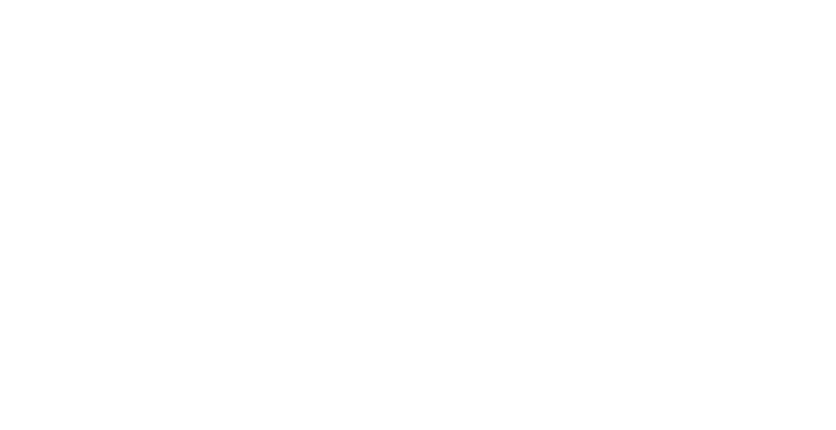

In [68]:
hp.mollview(maps_out, title ="HILC", cmap="viridis", min=-600, max=600)

$$
\hat{C}_{l}^{ij} = \frac{1}{2l+1}\sum_{m=-l}^{+l} a_{lm}^{i}a^{j \dagger }_{lm}
$$

After getting all indices construct a 1-d $a_{lm}$ array ranging from 1 to $\ell$. Calculate the $a_{lm}$ for $\ell = 0$. Compute the complex conjugate to get the $a_{lm}$ values for negative $\ell$. flip it (?). append to the positive $a_{lm}$ array. Then compute covariance using the above formula

In [10]:
diff = cmb_pl-ilc

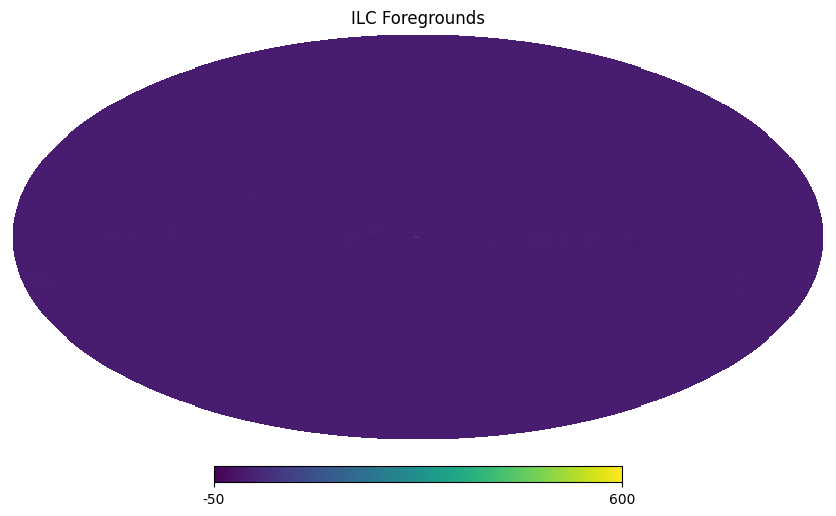

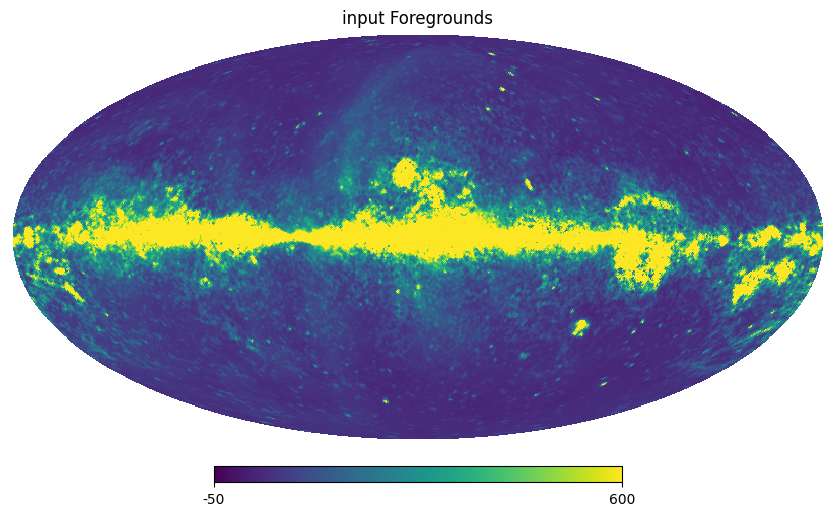

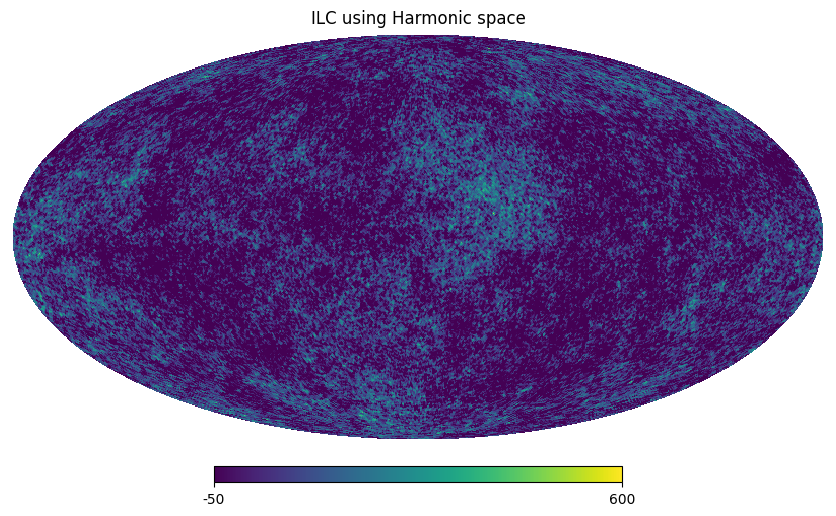

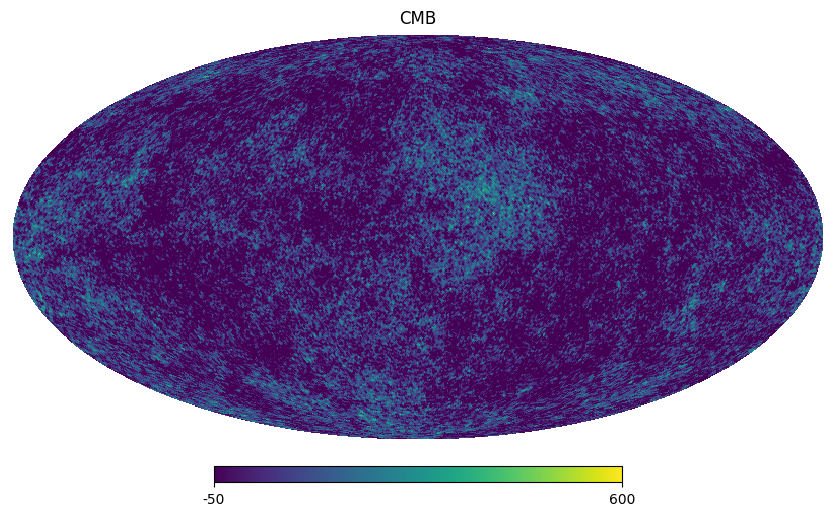

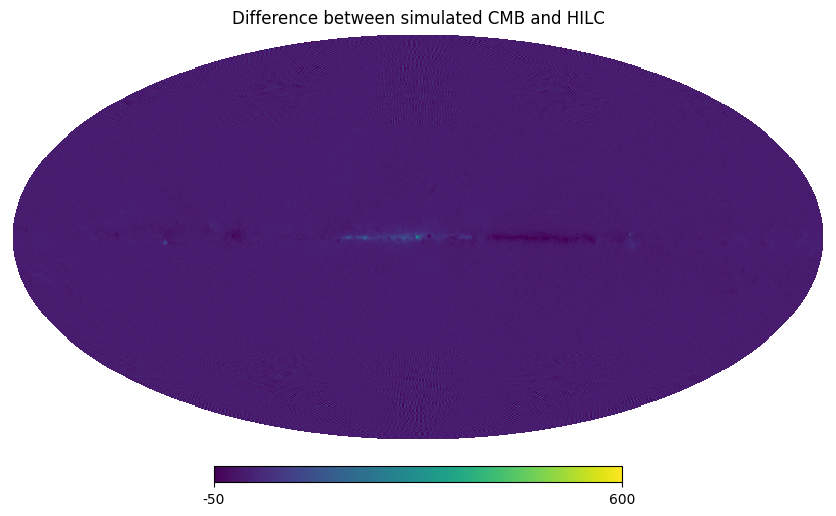

In [11]:
hp.mollview(ilc_fgds, title ="ILC Foregrounds", cmap="viridis", min=-50, max=600)
hp.mollview(fgds_pl[0], title ="input Foregrounds", cmap="viridis", min=-50, max=600)
hp.mollview(ilc, title ="ILC using Harmonic space", cmap="viridis", min=-50, max=600)
#hp.mollview(noise_pl[0], title ="Noise", cmap="viridis")
hp.mollview(cmb_pl[0], title ="CMB", cmap="viridis", min=-50, max=600)
hp.mollview(diff[0], title ="Difference between simulated CMB and HILC", cmap="viridis", min=-50, max=600)

In [12]:
# Compute the power spectrum
Cl = hp.anafast(ilc)

# Prepare the multipole values (ell)
l = np.arange(len(Cl))  # ell starts from 0

# Compute Dl = ell * (ell + 1) * Cl / (2 * pi)
Dl = l * (l + 1) * Cl / (2 * np.pi)

In [16]:
# Compute the cross power spectrum
Cl_c = hp.anafast(ilc, maps_pl)

# Prepare the multipole values (ell)
l_c = np.arange(len(Cl_c))  # ell starts from 0

# Compute Dl = ell * (ell + 1) * Cl / (2 * pi)
Dl_c = l_c * (l_c + 1) * Cl_c / (2 * np.pi)

ValueError: Wrong input map (must be a valid healpix map or a sequence of 1 or 3 maps)

/tmp/ipykernel_6295/1245572067.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False,fontsize=15)


Text(0.5, 1.0, 'Power spectra')

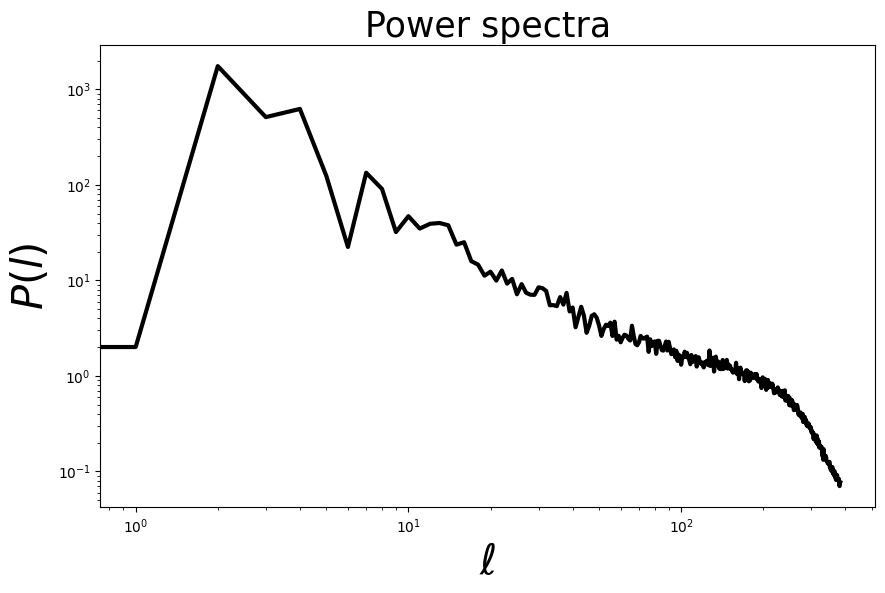

In [15]:
plt.figure(figsize=(10,6))
plt.plot(l, Cl,color='k',linewidth=3.)
#plt.plotl(Dl_c, l_c, color='r',label='Cross Power Spectrum',linewidth=3.)
plt.legend(frameon=False,fontsize=15)
plt.loglog()
#plt.xlim(3,400)
#plt.ylim(2e+1,3e+4)
plt.xlabel("$\ell$", fontsize=30)
plt.ylabel("$P(l)$", fontsize=30)
plt.title("Power spectra",fontsize=25.)